<a href="https://colab.research.google.com/github/Ruma13/skin_cancer-tl/blob/main/Final_model_GradCam%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')


Data split complete: Train=7010, Val=1001, Test=2004
Device: cuda
Classes: ['benign', 'malignant']


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 180MB/s]


Epoch 1/40 | Time 37.5s | Train Loss 0.4478 Acc 0.7879 | Val Loss 0.5434 Acc 0.7512
Epoch 2/40 | Time 35.9s | Train Loss 0.3856 Acc 0.8238 | Val Loss 0.4747 Acc 0.7552
Epoch 3/40 | Time 35.7s | Train Loss 0.3689 Acc 0.8361 | Val Loss 0.3833 Acc 0.8182
Epoch 4/40 | Time 35.7s | Train Loss 0.3512 Acc 0.8444 | Val Loss 0.3802 Acc 0.8501
Epoch 5/40 | Time 35.4s | Train Loss 0.2969 Acc 0.8718 | Val Loss 0.3707 Acc 0.8442
Epoch 6/40 | Time 35.8s | Train Loss 0.2823 Acc 0.8776 | Val Loss 0.4090 Acc 0.8531
Epoch 7/40 | Time 35.7s | Train Loss 0.2237 Acc 0.9091 | Val Loss 0.3519 Acc 0.8681
Epoch 8/40 | Time 35.5s | Train Loss 0.2072 Acc 0.9168 | Val Loss 0.5192 Acc 0.8302
Epoch 9/40 | Time 35.8s | Train Loss 0.2505 Acc 0.8966 | Val Loss 0.3350 Acc 0.8811
Epoch 10/40 | Time 35.3s | Train Loss 0.1761 Acc 0.9335 | Val Loss 0.3984 Acc 0.8611
Epoch 11/40 | Time 35.5s | Train Loss 0.1817 Acc 0.9267 | Val Loss 0.4331 Acc 0.8601
Epoch 12/40 | Time 35.6s | Train Loss 0.1522 Acc 0.9391 | Val Loss 0.3387 

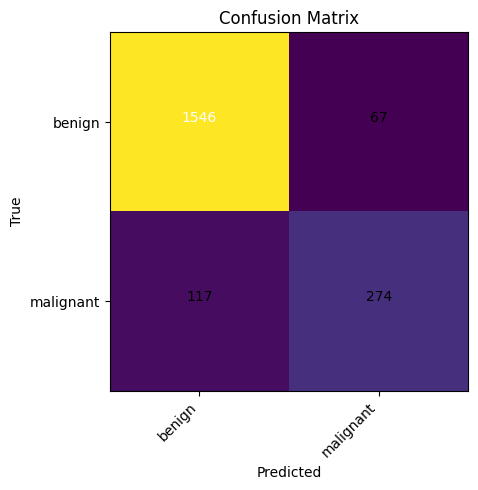

In [ ]:
import os
import math
import copy
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms, datasets

dataset_path = "/kaggle/input/skin-cancer-mnist-ham10000"

image_dir_1 = os.path.join(dataset_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(dataset_path, "HAM10000_images_part_2")
metadata_csv = os.path.join(dataset_path, "HAM10000_metadata.csv")

base_dir = "/kaggle/working/ham_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

#  CLEANUP
for d in [train_dir, val_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)


metadata = pd.read_csv(metadata_csv)
benign_classes = ["nv", "bkl", "df", "vasc"]
metadata["binary_label"] = metadata["dx"].apply(lambda x: 0 if x in benign_classes else 1)

# Collect images
all_images = []
for _, row in metadata.iterrows():
    img_id = row["image_id"]
    label = "malignant" if row["binary_label"] == 1 else "benign"
    img_path = os.path.join(image_dir_1, img_id + ".jpg")
    if not os.path.exists(img_path):
        img_path = os.path.join(image_dir_2, img_id + ".jpg")
    all_images.append((img_path, label))

# Split dataset
train_images, temp_images = train_test_split(
    all_images,
    test_size=0.3,
    stratify=[lbl for _, lbl in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=2/3,
    stratify=[lbl for _, lbl in temp_images],
    random_state=42
)

# Copy images to directories
def copy_images(img_label_list, dest_dir):
    for img_path, label in img_label_list:
        class_dir = os.path.join(dest_dir, label)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(img_path, class_dir)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)
print(f"Data split complete: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

img_size = 224
batch_size = 32
num_workers = 4

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset   = datasets.ImageFolder(val_dir, transform=data_transforms["val"])
test_dataset  = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Compute class weights
labels = [y for _, y in train_dataset.samples]
class_counts = np.bincount(labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

#  CBAM MODULE
class ChannelAttention(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(in_channels // reduction, 1)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, in_channels, bias=False)
        )
        self.pool_avg = nn.AdaptiveAvgPool2d(1)
        self.pool_max = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg = self.pool_avg(x).view(b, c)
        mx  = self.pool_max(x).view(b, c)
        attn = self.mlp(avg) + self.mlp(mx)
        attn = self.sigmoid(attn).view(b, c, 1, 1)
        return x * attn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        feat = torch.cat([avg, mx], dim=1)
        attn = self.sigmoid(self.conv(feat))
        return x * attn

class CBAM(nn.Module):
    def __init__(self, in_channels: int, reduction: int = 16):
        super().__init__()
        self.ca = ChannelAttention(in_channels, reduction)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x))

# MODEL
class DenseNetCBAMFusion(nn.Module):
    def __init__(self, num_classes=2, unfreeze_last_block=True, mid_channels=1024):
        super().__init__()
        backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.stem = backbone.features
        in_ch = 1024
        for p in self.stem.parameters():
            p.requires_grad = False
        if unfreeze_last_block:
            for p in list(self.stem[-6:].parameters()):
                p.requires_grad = True

        self.attn = CBAM(in_ch)
        self.mid = nn.Sequential(
            nn.Conv2d(in_ch, mid_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(mid_channels, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.attn(x)
        x = self.mid(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

model = DenseNetCBAMFusion(num_classes=num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad],
                              lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

#  TRAIN / EVALUATE FUNCTIONS
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_logits, all_targets = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())
    return total_loss / total, correct / total, torch.cat(all_logits), torch.cat(all_targets)


val_acc_cbam_fusion = []
val_loss_cbam_fusion = []

#  TRAINING LOOP
best_acc = 0
best_wts = copy.deepcopy(model.state_dict())
patience = 5
epochs_no_improve = 0
epochs = 40

for epoch in range(1, epochs+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_logits, val_targets = evaluate(model, val_loader)

    # Append to lists
    val_acc_cbam_fusion.append(val_acc)
    val_loss_cbam_fusion.append(val_loss)

    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, "best_cbam_fusion.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch}/{epochs} | Time {time.time()-t0:.1f}s | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | "
          f"Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    if epochs_no_improve >= patience:
        print("Early stopping.")
        break

# Load best model
model.load_state_dict(best_wts)

test_loss, test_acc, test_logits, test_targets = evaluate(model, test_loader)
print(f"TEST | Loss {test_loss:.4f} Acc {test_acc:.4f}")

def plot_confusion_matrix(logits, targets, classes):
    preds = logits.argmax(dim=1).numpy()
    y_true = targets.numpy()
    cm = confusion_matrix(y_true, preds, labels=list(range(len(classes))))

    fig = plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Add counts
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_logits, test_targets, class_names)


In [ ]:
torch.save(best_wts, "best_cbam_fusion.pth")


Found 2004 test images
Using image: /kaggle/working/ham_split/test/benign/ISIC_0029325.jpg


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


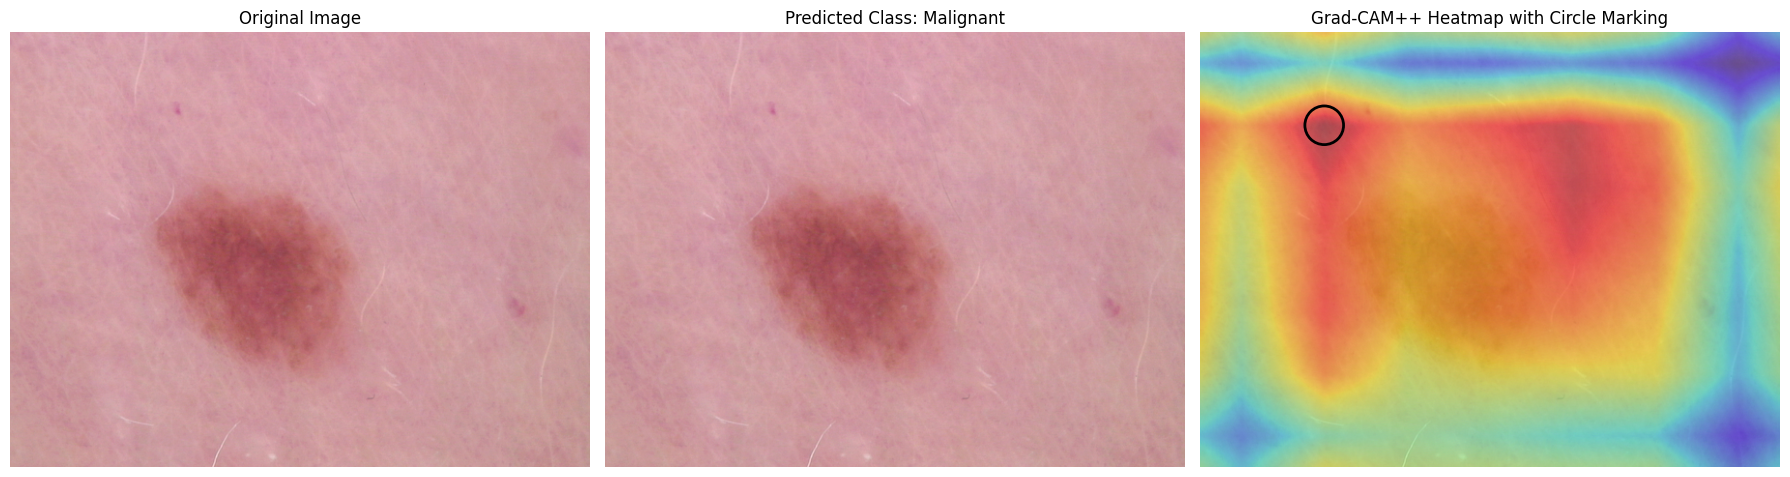

✅ Model saved to: /kaggle/working/skin_cancer_best_model.pth


In [ ]:
import glob

# Pick the first image from the malignant class
test_images = glob.glob("/kaggle/working/ham_split/test/*/*.jpg")
print(f"Found {len(test_images)} test images")
image_path = test_images[0]  # Use first image
print("Using image:", image_path)

plot_gradcam_pp(model, image_path, last_conv_layer_name="features.denseblock4.denselayer16.conv2")

save_path = "/kaggle/working/skin_cancer_best_model.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to: {save_path}")


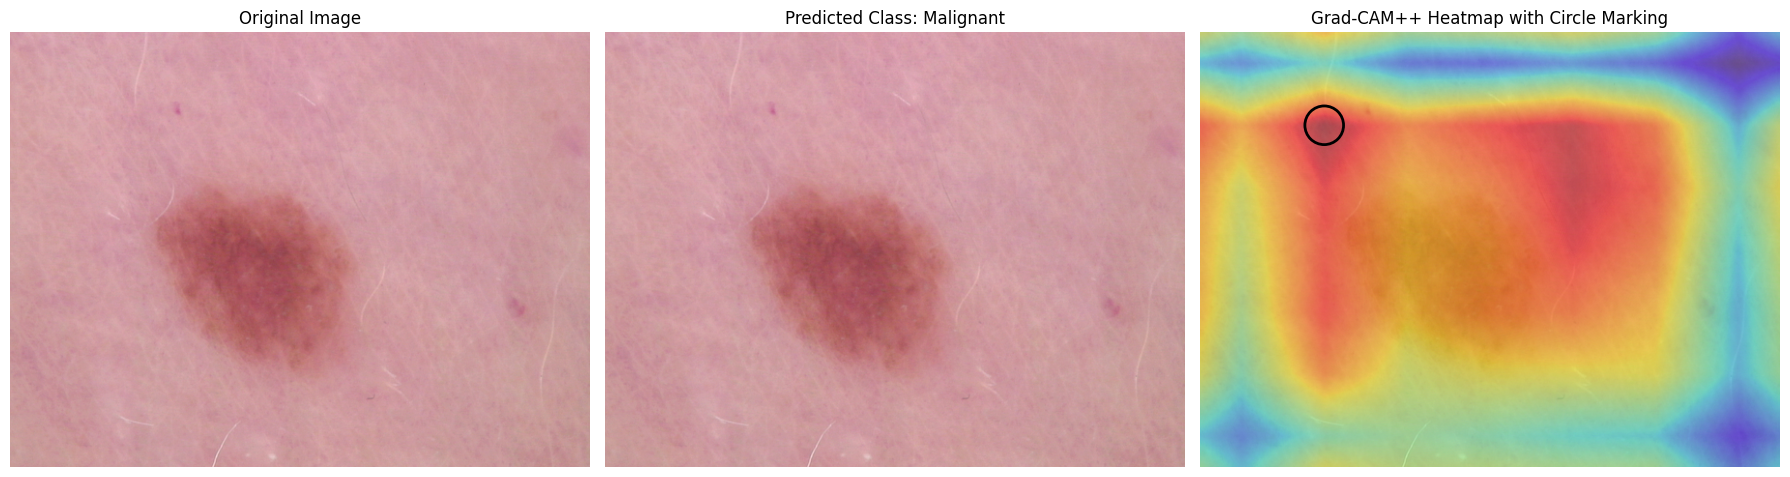

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model architecture (replace with your model definition!)
from torchvision import models
model = models.densenet121(weights=None, num_classes=2)  # Example: DenseNet121 with binary classification
model.load_state_dict(torch.load("/kaggle/working/skin_cancer_best_model.pth", map_location=device))
model.to(device)
model.eval()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ImageNet normalization
])


#  GRAD-CAM++ IMPLEMENTATION

def gradcam_pp(model, img_tensor, target_class, last_conv_layer_name):
    conv_output = None
    conv_grad = None

    # Hook for forward pass
    def forward_hook(module, input, output):
        nonlocal conv_output
        conv_output = output.detach()

    # Hook for backward pass
    def backward_hook(module, grad_input, grad_output):
        nonlocal conv_grad
        conv_grad = grad_output[0].detach()

    # Register hooks
    for name, module in model.named_modules():
        if name == last_conv_layer_name:
            handle_f = module.register_forward_hook(forward_hook)
            handle_b = module.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backward pass for target class
    model.zero_grad()
    class_score = output[:, target_class]
    class_score.backward(retain_graph=True)

    # Remove hooks
    handle_f.remove()
    handle_b.remove()

    # Grad-CAM++ computation
    grads = conv_grad  # [B, C, H, W]
    activations = conv_output  # [B, C, H, W]

    grads_power_2 = grads ** 2
    grads_power_3 = grads ** 3
    sum_activations = torch.sum(activations, dim=(2, 3), keepdim=True)

    alpha_num = grads_power_2
    alpha_denom = 2 * grads_power_2 + sum_activations * grads_power_3
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

    alphas = alpha_num / alpha_denom
    positive_grads = F.relu(grads)
    weights = (alphas * positive_grads).sum(dim=(2, 3))

    cam = (weights[:, :, None, None] * activations).sum(dim=1)
    cam = F.relu(cam)
    cam = cam[0].cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam, pred_class


#  PLOT FUNCTION

def plot_gradcam_pp(model, image_path, last_conv_layer_name):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Forward pass to get prediction
    with torch.no_grad():
        output = model(img_tensor)
        predicted_class = output.argmax(dim=1).item()

    label = "Benign" if predicted_class == 0 else "Malignant"

    # Grad-CAM++ heatmap
    heatmap, _ = gradcam_pp(model, img_tensor, predicted_class, last_conv_layer_name)
    heatmap_resized = resize(heatmap, (img.size[1], img.size[0]))
    heatmap_smoothed = gaussian_filter(heatmap_resized, sigma=2)

    # Find max activation
    max_y, max_x = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)

    # Plotting
    fig = plt.figure(figsize=(18, 6))

    # Original Image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis("off")

    # Predicted Class
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(img)
    ax2.set_title(f"Predicted Class: {label}")
    ax2.axis("off")

    # Grad-CAM++ Heatmap
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(img)
    ax3.imshow(heatmap_smoothed, cmap='jet', alpha=0.5)
    ax3.set_title("Grad-CAM++ Heatmap with Circle Marking")
    ax3.axis("off")

    circle_radius = 20
    circle = plt.Circle((max_x, max_y), circle_radius, color='black', fill=False, linewidth=2)
    ax3.add_patch(circle)

    plt.tight_layout()
    plt.savefig("GradCAM++_Result.png", dpi=600, bbox_inches="tight")
    plt.show()


#  EXAMPLE USAGE
mage_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg"
plot_gradcam_pp(model, image_path, last_conv_layer_name="features.denseblock4.denselayer16.conv2")



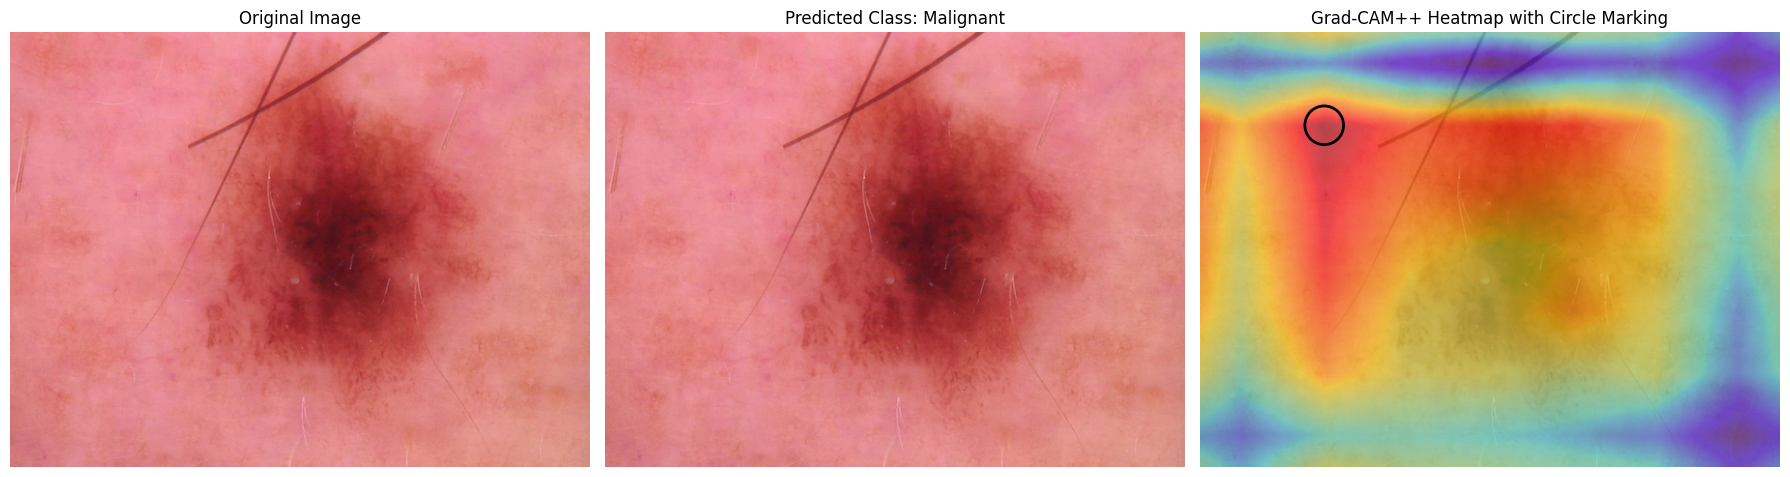

In [ ]:

image_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg"
plot_gradcam_pp(model, image_path, last_conv_layer_name="features.denseblock4.denselayer16.conv2")

